# Определение перспективного тарифа для телеком-компании

__Примечание:__

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Изучение данных из файлов

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import warnings
import seaborn as sns

In [2]:
warnings.simplefilter('ignore')

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0) # Убираем колонку Unnamed
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим по отдельности каждую таблицу.

In [3]:
df = [
    calls,
    internet,
    messages,
    tariffs,
    users
]

for i in range(len(df)):
    display(df[i].head())
    print('Количество дублей:', df[i].duplicated().sum())
    df[i].info()
    print(df[i].isna().sum())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Количество дублей: 0

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 202607 entries, 0 to 202606

Data columns (total 4 columns):

id           202607 non-null object

call_date    202607 non-null object

duration     202607 non-null float64

user_id      202607 non-null int64

dtypes: float64(1), int64(1), object(2)

memory usage: 6.2+ MB

id           0

call_date    0

duration     0

user_id      0

dtype: int64


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


Количество дублей: 0

<class 'pandas.core.frame.DataFrame'>

Int64Index: 149396 entries, 0 to 149395

Data columns (total 4 columns):

id              149396 non-null object

mb_used         149396 non-null float64

session_date    149396 non-null object

user_id         149396 non-null int64

dtypes: float64(1), int64(1), object(2)

memory usage: 5.7+ MB

id              0

mb_used         0

session_date    0

user_id         0

dtype: int64


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Количество дублей: 0

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 123036 entries, 0 to 123035

Data columns (total 3 columns):

id              123036 non-null object

message_date    123036 non-null object

user_id         123036 non-null int64

dtypes: int64(1), object(2)

memory usage: 2.8+ MB

id              0

message_date    0

user_id         0

dtype: int64


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Количество дублей: 0

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 2 entries, 0 to 1

Data columns (total 8 columns):

messages_included        2 non-null int64

mb_per_month_included    2 non-null int64

minutes_included         2 non-null int64

rub_monthly_fee          2 non-null int64

rub_per_gb               2 non-null int64

rub_per_message          2 non-null int64

rub_per_minute           2 non-null int64

tariff_name              2 non-null object

dtypes: int64(7), object(1)

memory usage: 256.0+ bytes

messages_included        0

mb_per_month_included    0

minutes_included         0

rub_monthly_fee          0

rub_per_gb               0

rub_per_message          0

rub_per_minute           0

tariff_name              0

dtype: int64


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Количество дублей: 0

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 500 entries, 0 to 499

Data columns (total 8 columns):

user_id       500 non-null int64

age           500 non-null int64

churn_date    38 non-null object

city          500 non-null object

first_name    500 non-null object

last_name     500 non-null object

reg_date      500 non-null object

tariff        500 non-null object

dtypes: int64(2), object(6)

memory usage: 31.4+ KB

user_id         0

age             0

churn_date    462

city            0

first_name      0

last_name       0

reg_date        0

tariff          0

dtype: int64


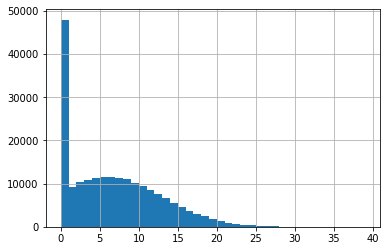

In [4]:
calls['duration'].hist(bins=range(0, 40, 1))

* Будь это любой другой случай, можно было задуматься об удалении аномальных значений. Но т.к. это звонки, где вполне реальны разговоры менее одной минуты, например, прозвоны от колл-центров/спам-звонки, то лучше их оставить.

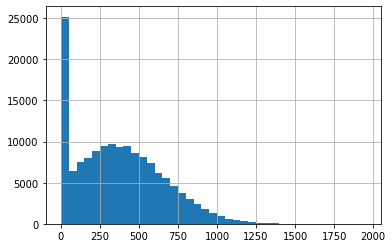

In [5]:
internet['mb_used'].hist(bins=range(0, 2000, 50))

In [6]:
print('Количество сессий с расходом трафика менее 50 мб:', internet[internet['mb_used'] < 50]['user_id'].count())

Количество сессий с расходом трафика менее 50 мб: 25178


* С расходом трафика менее 50 мб за одну сессию тоже вполне понятно: пользователь может просто написать какое-нибудь письмо, или зайти в интернете прочитать какой то текст. Все, что не требует большого расхода трафика. Удалять эти сессии не стоит, тем более их более 20 процентов от всех сессий.

### Вывод

Первичный осмотр данных позволяет нам увидеть, что:
* в названиях колонках нет ошибок;
* явных дубликатов нигде нет;
* есть пропуски в количестве 462 штук в таблице `users` колонке `churn_date`, скорее всего, это пользователи, кто еще не закончили сотрудничать с компанией;
* в таблицах `calls` и `internet` в колонках `duration` и `mb_used` округлить в минуты и гигабайты соответственно;
* в таблицах `calls`, `internet`, `message` и `users` в колонках `call_date` `session_date`, `message_date` и `reg_date` соответственно надо перевести в тип `datetime`.

## Подготовка данных

### Замена типов, ошибки, заполнение пропусков и т.д.

Поменяем типы данных на те, которые обговорили.

In [7]:
# Переведем все колонки с датами в тип datetime:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [8]:
# Округлим в большую сторону длительность звонка и переведем в целочисленный тип:
calls['duration'] = np.ceil(calls['duration'])
calls['duration'] = calls['duration'].astype('Int64')

# Т.к. мб в интернет траффике считаются за месяц, то округим их в большую сторону при добавлении нового столбца "месяц"

In [9]:
# Добавляем в каждую таблицу колонку month
calls['calls_month'] = pd.DatetimeIndex(calls['call_date']).month
messages['message_month'] = pd.DatetimeIndex(messages['message_date']).month
internet['session_month'] = pd.DatetimeIndex(internet['session_date']).month

# Группируем по user_id и месяцу
calls_month = calls.groupby(['user_id', 'calls_month'], as_index=False)['duration'].agg('sum')   # Суммируем длительность
calls_month.columns = ['user_id', 'month', 'call_duration']

messages_month = messages.groupby(['user_id', 'message_month'], as_index=False)['id'].agg('count')    # Считаем кол-во сообщений
messages_month.columns = ['user_id', 'month', 'message_count']

internet_month = internet.groupby(['user_id', 'session_month'], as_index=False)['mb_used'].agg('sum')  # Считаем кол-во мб за месяц
internet_month.columns = ['user_id', 'month', 'mb_used']

# Теперь округлим мегабайты в гигабайты в большую сторону

internet_month['gb_used'] = internet_month['mb_used'] / 1024
internet_month['gb_used'] = np.ceil(internet_month['gb_used']).astype('Int64') # и переведем в целочисленный тип
internet_month = internet_month.drop('mb_used', axis=1) # Удалила лишнюю колонку с мегабайтами

calls['calls_month'] = calls['calls_month'].astype('Int64')


internet_month.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


In [10]:
internet_month.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


* Таким образом посчитали ежемесячную трату трафика в гигабайтах.

In [11]:
messages_month.head()

,user_id,month,message_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


* Здесь можно увидеть кол-во отправленных сообщений по месяцам

In [12]:
calls_month.head()

,user_id,month,call_duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


* Можем посмотреть на количество минут, потраченных на звонки в каждом месяце.

Для удобства хранения переведем колонку `tariff_name` в целочисленный тип, где `smart` и `ultra` переведем в  `0` и `1` соответственно.

In [13]:
tariffs['tariff_name'] = tariffs['tariff_name'].replace('smart', 0)
tariffs['tariff_name'] = tariffs['tariff_name'].replace('ultra', 1)

users['tariff'] = users['tariff'].replace('smart', 0)
users['tariff'] = users['tariff'].replace('ultra', 1)
users['tariff'] = pd.to_numeric(users['tariff'], downcast='integer') 

Теперь объединим таблицы в одну, чтобы было удобнее считать.

In [14]:
earnings = (calls_month
            .merge(messages_month, on = ['user_id', 'month'], how='outer')
            .merge(internet_month, on = ['user_id', 'month'], how='outer')
            # методом merge() добавим идентификатор тарифа 'tariff' из таблицы 'users'
            # how='left' для прикрепления тарифа к каждой имеющейся записи в таблице 'earnings' 
            .merge(users[['user_id', 'tariff', 'city']], how='outer', on='user_id')
           )

# Переиминуем колонку для общей связки с таблицей тарифов:
earnings.rename(columns={'tariff': 'tariff_name'}, inplace=True)

earnings = earnings.merge(tariffs, on='tariff_name', how='left')

earnings

,user_id,month,call_duration,message_count,gb_used,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,159,22.0,3,1,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6.0,172,60.0,23,1,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7.0,340,75.0,14,1,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8.0,408,81.0,14,1,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9.0,466,57.0,15,1,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,21.0,20,0,Санкт-Петербург,50,15360,500,550,200,3,3
3212,1489,11.0,NaN,20.0,18,0,Санкт-Петербург,50,15360,500,550,200,3,3
3213,1489,12.0,NaN,35.0,17,0,Санкт-Петербург,50,15360,500,550,200,3,3
3214,1128,NaN,NaN,NaN,NaN,1,Волжский,1000,30720,3000,1950,150,1,1


In [15]:
# Комментарий ревьюера
earnings.user_id.unique().shape

(500,)

* Соединили таблицы, теперь можно приступать к расчетам.

In [16]:
# Определяем функцию для подсчета дохода по каждой строке датафрейма
def defend_earnings(row):
    summ = row['rub_monthly_fee']
    if row['call_duration'] > row['minutes_included']:
        summ += abs((row['call_duration'] - row['minutes_included']) * row['rub_per_minute'])
    if row['message_count'] > row['messages_included']:
        summ += abs((row['message_count'] - row['messages_included']) * row['rub_per_message'])
    if row['gb_used'] > (row['mb_per_month_included'] / 1024):
        summ += abs((row['gb_used'] - (row['mb_per_month_included'] / 1024)) * row['rub_per_gb'])
    return summ 

earnings['earning'] = earnings.apply(defend_earnings, axis=1).astype('Int64')
earnings

,user_id,month,call_duration,message_count,gb_used,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,earning
0,1000,5.0,159,22.0,3,1,Краснодар,1000,30720,3000,1950,150,1,1,1950
1,1000,6.0,172,60.0,23,1,Краснодар,1000,30720,3000,1950,150,1,1,1950
2,1000,7.0,340,75.0,14,1,Краснодар,1000,30720,3000,1950,150,1,1,1950
3,1000,8.0,408,81.0,14,1,Краснодар,1000,30720,3000,1950,150,1,1,1950
4,1000,9.0,466,57.0,15,1,Краснодар,1000,30720,3000,1950,150,1,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,21.0,20,0,Санкт-Петербург,50,15360,500,550,200,3,3,1550
3212,1489,11.0,NaN,20.0,18,0,Санкт-Петербург,50,15360,500,550,200,3,3,1150
3213,1489,12.0,NaN,35.0,17,0,Санкт-Петербург,50,15360,500,550,200,3,3,950
3214,1128,NaN,NaN,NaN,NaN,1,Волжский,1000,30720,3000,1950,150,1,1,1950


* Таким образом посчитали для каждого пользователся доход в каждом месяце.

In [17]:
# Комментарий ревьюера
earnings.info()

<class 'pandas.core.frame.DataFrame'>

Int64Index: 3216 entries, 0 to 3215

Data columns (total 15 columns):

user_id                  3216 non-null int64

month                    3214 non-null float64

call_duration            3174 non-null Int64

message_count            2717 non-null float64

gb_used                  3203 non-null Int64

tariff_name              3216 non-null int8

city                     3216 non-null object

messages_included        3216 non-null int64

mb_per_month_included    3216 non-null int64

minutes_included         3216 non-null int64

rub_monthly_fee          3216 non-null int64

rub_per_gb               3216 non-null int64

rub_per_message          3216 non-null int64

rub_per_minute           3216 non-null int64

earning                  3216 non-null Int64

dtypes: Int64(3), float64(2), int64(8), int8(1), object(1)

memory usage: 389.4+ KB


In [18]:
display(earnings[earnings['month'].isna()])

,user_id,month,call_duration,message_count,gb_used,tariff_name,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,earning
3214,1128,NaN,NaN,NaN,NaN,1,Волжский,1000,30720,3000,1950,150,1,1,1950
3215,1371,NaN,NaN,NaN,NaN,0,Омск,50,15360,500,550,200,3,3,550


* Видно, что в этих двух строках нет данных, которые были бы нам полезны и по которым можно сделать анализ. Поэтому удолим.

In [19]:
earnings = earnings.dropna(subset=['month'], how='all')
earnings['month'].isna().sum()

0

* Удалила две строки.

## Анализ данных

### Описание поведения клиентов оператора (сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц)

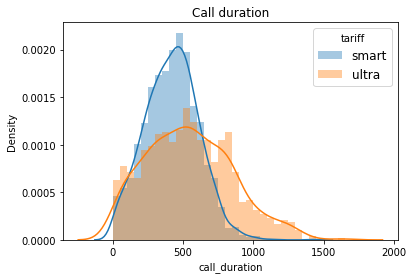

In [20]:
#sns.set_style('whitegrid')
#sns.kdeplot(np.array(earnings['call_duration']))

sns.distplot(earnings.query('tariff_name == 0')['call_duration'].dropna(), 
            hist=True, kde=True, 
            bins=range(0, 1675, 50), 
            label='smart')
plt.legend(prop={'size': 12}, title = 'tariff')
plt.title('Call duration')
plt.ylabel('Density')
sns.distplot(earnings.query('tariff_name == 1')['call_duration'].dropna(),
             hist=True,
             kde=True,
             bins=range(0, 1675, 50),
             label='ultra')
plt.legend(prop={'size': 12}, title = 'tariff')

* Большая часть значений лежит в пределе от 300 до 600 минут разговоров за месяц для тарифа `smart`. Но у пользователей с тарифом `ultra` большой хвост вправо, значит, эти пользователи чаще первых пользователей говорят больше 700 минут.

In [21]:
temp_message = earnings.query('tariff_name == 1')['message_count'].dropna()
temp_message.max()

224.0

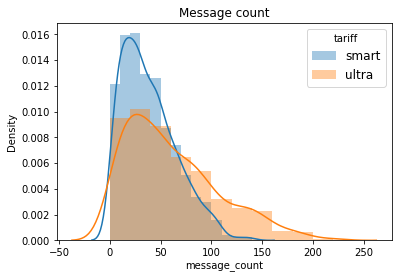

In [22]:
sns.distplot(earnings.query('tariff_name == 0')['message_count'].dropna(), 
            hist=True, kde=True, 
            bins=range(0, 225, 10), 
            label='smart')
plt.legend(prop={'size': 12}, title = 'tariff')
plt.title('Message count')
plt.ylabel('Density')
sns.distplot(earnings.query('tariff_name == 1')['message_count'].dropna(),
             hist=True,
             kde=True,
             bins=range(0, 225, 20),
             label='ultra')
plt.legend(prop={'size': 12}, title = 'tariff')

* То же самое здесь: пользователи с тарифом `ultra` чаще отправляют более 90 сообщений в месяц, также график скошен вправо.

In [23]:
earnings.query('tariff_name == 1')['gb_used'].dropna().max()

49

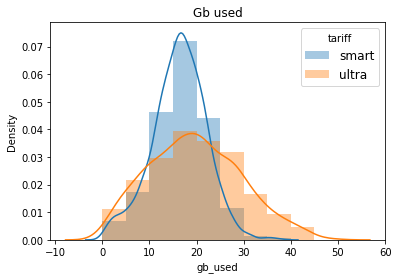

In [24]:
sns.distplot(earnings.query('tariff_name == 0')['gb_used'].dropna(), 
            hist=True, kde=True, 
            bins=range(0, 50, 5), 
            label='smart')
plt.legend(prop={'size': 12}, title = 'tariff')
plt.title('Gb used')
plt.ylabel('Density')
sns.distplot(earnings.query('tariff_name == 1')['gb_used'].dropna(),
             hist=True,
             kde=True,
             bins=range(0, 50, 5),
             label='ultra')
plt.legend(prop={'size': 12}, title = 'tariff')

* У пользователей с тарифом `smart` частота траты от 15 до 20 ГБ выше, чем у пользователей с тарифом `ultra`. Но пользователи с тарифом `ultra`чаще использую больше 25 ГБ в месяц.

### Посчитайте среднее количество, дисперсию и стандартное отклонение.  Опишите распределения.

In [25]:
print('Среднее время диалога за месяц по тарифу smart:', earnings.query('tariff_name == 0')['call_duration'].mean())
print('Среднее время диалога за месяц по тарифу ultra:', earnings.query('tariff_name == 1')['call_duration'].mean())
print()
print('Среднее кол-во сообщений за месяц по тарифу smart:', earnings.query('tariff_name == 0')['message_count'].mean())
print('Среднее кол-во сообщений за месяц по тарифу ultra:', earnings.query('tariff_name == 1')['message_count'].mean())
print()
print('Среднее кол-во гигабайт за месяц по тарифу smart:', earnings.query('tariff_name == 0')['gb_used'].mean())
print('Среднее кол-во гигабайт за месяц по тарифу ultra:', earnings.query('tariff_name == 1')['gb_used'].mean())

Среднее время диалога за месяц по тарифу smart: 419.0629779577148

Среднее время диалога за месяц по тарифу ultra: 545.4511041009464



Среднее кол-во сообщений за месяц по тарифу smart: 38.71644120707596

Среднее кол-во сообщений за месяц по тарифу ultra: 61.161006289308176



Среднее кол-во гигабайт за месяц по тарифу smart: 16.33617594254937

Среднее кол-во гигабайт за месяц по тарифу ultra: 19.694358974358973


In [26]:
print('Дисперсия времени диалога за месяц по тарифу smart', np.var(earnings.query('tariff_name == 0')['call_duration']))
print('Дисперсия времени диалога за месяц по тарифу ultra', np.var(earnings.query('tariff_name == 1')['call_duration']))
print()
print('Дисперсия кол-ва сообщений за месяц по тарифу smart', np.var(earnings.query('tariff_name == 0')['message_count']))
print('Дисперсия кол-ва сообщений за месяц по тарифу ultra', np.var(earnings.query('tariff_name == 1')['message_count']))
print()
print('Дисперсия кол-ва гигабайт за месяц по тарифу smart', np.var(earnings.query('tariff_name == 0')['gb_used']))
print('Дисперсия кол-ва гигабайт за месяц по тарифу ultra', np.var(earnings.query('tariff_name == 1')['gb_used']))

Дисперсия времени диалога за месяц по тарифу smart 35844.1895513438

Дисперсия времени диалога за месяц по тарифу ultra 94203.41839614812



Дисперсия кол-ва сообщений за месяц по тарифу smart 717.220843110227

Дисперсия кол-ва сообщений за месяц по тарифу ultra 2107.0055235156838



Дисперсия кол-ва гигабайт за месяц по тарифу smart 32.92375582354312

Дисперсия кол-ва гигабайт за месяц по тарифу ultra 94.14673405991682


In [27]:
duration_smart_disp = np.var(earnings.query('tariff_name == 0')['call_duration'])
duration_ultra_disp = np.var(earnings.query('tariff_name == 1')['call_duration'])

message_smart_disp = np.var(earnings.query('tariff_name == 0')['message_count'])
message_ultra_disp = np.var(earnings.query('tariff_name == 1')['message_count'])

gb_smart_disp = np.var(earnings.query('tariff_name == 0')['gb_used'])
gb_ultra_disp = np.var(earnings.query('tariff_name == 1')['gb_used'])

print('Стандартное отклонение времени диалога по тарифу smart',
      np.sqrt(np.var(earnings.query('tariff_name == 0')['call_duration'])))
print('Стандартное отклонение времени диалога по тарифу ultra',
      np.sqrt(np.var(earnings.query('tariff_name == 1')['call_duration'])))
print()
print('Стандартное отклонение кол-ва сообщений по тарифу smart:',
      np.sqrt(np.var(earnings.query('tariff_name == 0')['message_count'])))
print('Стандартное отклонение кол-ва сообщений по тарифу ultra:',
      np.sqrt(np.var(earnings.query('tariff_name == 1')['message_count'])))
print()
print('Стандартное отклонение гигабайт по тарифу smart',
      np.sqrt(np.var(earnings.query('tariff_name == 0')['gb_used'])))
print('Стандартное отклонение гигабайт по тарифу ultra',
      np.sqrt(np.var(earnings.query('tariff_name == 1')['gb_used'])))

Стандартное отклонение времени диалога по тарифу smart 189.3256177894154

Стандартное отклонение времени диалога по тарифу ultra 306.92575388218586



Стандартное отклонение кол-ва сообщений по тарифу smart: 26.780979129042816

Стандартное отклонение кол-ва сообщений по тарифу ultra: 45.90212983637779



Стандартное отклонение гигабайт по тарифу smart 5.737922605224221

Стандартное отклонение гигабайт по тарифу ultra 9.70292399536948


### Вывод
* Среднее у тарифа `ultra` по всем показателям больше.
* Дисперсия и стандартное отклонение у тарифа `ultra` по всем показателям больше. Это означает, что пользователь с этим тарифом с большей вероятностью может использовать больше минут и гигабайт или написать большее кол-во сообщений. 
* Распределение у всех графиков сводится к нормальному.
* Графики с тарифом `ultra` скошены вправо.

In [28]:
# Комментарий ревьюера
temp_call = earnings.query('tariff_name == 1')['call_duration'].dropna()
temp_call.max()

1673

## Проверка гипотез и пояснения

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулирем нулевую гипотезу, исходя от обратного: _Средняя выручка пользователей тарифов "ультра" и "смарт" равны._
Вследствие этого альтернативная гипотеза будет звучать, как: _Средняя выручка пользователей тарифов "ультра" и "смарт" не равны._

In [29]:
#smart_vs_ultra = earnings.pivot_table(index='tariff_name')
#smart_vs_ultra
smart = earnings[earnings['tariff_name'] == 0]['earning']
ultra = earnings[earnings['tariff_name'] == 1]['earning']

alpha = .05

results = st.ttest_ind(
    smart,
    ultra,
    equal_var=False
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-value: 4.260631393081911e-250

Отвергаем нулевую гипотезу


### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Сформулируем нулевую гипотезу для этой ситауции: _Средняя выручка пользователей Москвы не отличается от выручки пользователей из другиз регионов._ Следовательно альтернативная гипотеза будет: _Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов._

In [30]:
# Среднее по Москве
moscow = earnings[earnings['city'] == 'Москва']['earning']
# Среднее по остальным городам
other = earnings[earnings['city'] != 'Москва']['earning']

alpha = .05

results = st.ttest_ind(
    moscow,
    other,
    equal_var=False
)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-value: 0.5257376663729292

Не получилось отвергнуть нулевую гипотезу


### Вывод

Таким образом, в двух сравнениях мы отвергаем нулевую гипотезу в пользу следующих:
1. Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются — верно.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов — не верно. Они одинаковы.

При проверке гипотез я использовала p-значение, которые показывает для значения вероятность "далекости" от среднего.

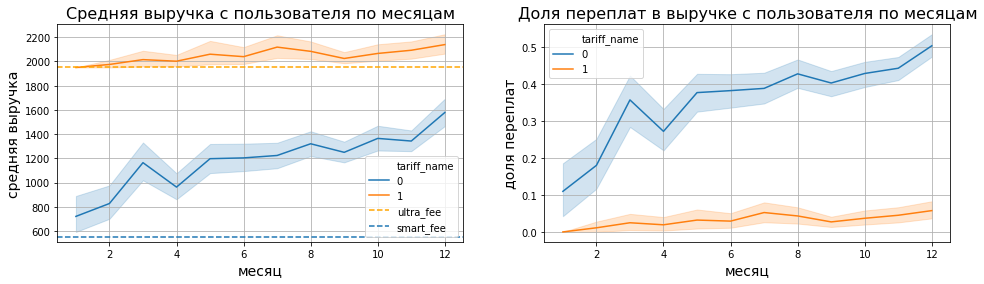

In [31]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,4))   # создадим оси для двух гистограмм друг напротив друга

# в axes[0] (слева) построим среднюю выручку с одного пользователя по месяцам
lines = sns.lineplot(x='month', 
                     y='earning', 
                     data=earnings, 
                     hue='tariff_name',
                     estimator='mean',
                     ax=axes[0])
# отобразим горизонтальными линиями абонентскую плату по каждому тарифу
lines.axhline(1950, ls='--', label='ultra_fee', color='orange')
lines.axhline(550, ls='--', label='smart_fee')
axes[0].set_title('Средняя выручка с пользователя по месяцам', fontsize=16)
axes[0].set_xlabel('месяц', fontsize=14)
axes[0].set_ylabel('средняя выручка', fontsize=14)
axes[0].grid()
axes[0].legend()

# в axes[1] (справа) построим долю переплат в средней выручке с одного пользователя по месяцам
sns.lineplot(x='month', 
             y=(earnings['earning']-earnings['rub_monthly_fee'])/earnings['earning'], 
             data=earnings, 
             hue='tariff_name',
             estimator='mean',
             ax = axes[1])
axes[1].set_title('Доля переплат в выручке с пользователя по месяцам', fontsize=16)
axes[1].set_xlabel('месяц', fontsize=14)
axes[1].set_ylabel('доля переплат', fontsize=14)
plt.grid()

## Общий вывод

В работе я сделала:
1. Привела все данные к нужным типам.
2. Проверила данные, в данных ошибок не было.
3. Посчитала для каждого пользователя кол-во звонкв, минут, сообщений, гигабайт за месяц
4. Округлила минуты звонков и мегабайты интернета по правилам компании.
5. Посчитала помесячную выручку с каждого пользователя
6. Высчитала среднее, дисперсию и стандартное отклонение для трех показателей.

Исходя из исследования, можно сделать вывод, что:
* Пользователи тарифа `ultra` реже используют больше трафика, чем предназначено их пакетом.
* Пользователи тарифа `smart` чаще превышают свой пакет и вынуждены доплачивать.
* От пользователей тарифа `ultra` средний доход по месяцам выше, чем от пользователей с тарифом `smart`
* У пользователей тарифа `ultra` менее выраженный тренд на увеличение средней выручки, чем у пользователей тарифа `smart`.
* Среди пользователей тарифа `smart` обнаружен рост средней выручки с пользователя с течением времени. За год доля переплат от средней выручки с пользователя выросла с 10% до 50%. Это может привести к негативным отзывам со стороны клиентов. Среди пользователей тарифа `ultra` эта тенденция значительно меньше (доля переплат около 5%). __Для продвижения стоит выбрать тариф `ultra`.__
* __Если наша цель является доходом, то благодаря переплате выгоднее для компании продвигать `smart`.__